In [22]:
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = SelfAttention(inp)  # Attention layer with input dimension
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Applying attention first
        attn_out = self.attention(x)
        # Feeding the output of the attention layer into the RNN
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Applying the final output layer
        out = torch.sigmoid(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Feeding the output of the attention layer into the RNN
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


model = NetRNNWithAttention()

In [4]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
        return numpy.array(O), numpy.array(H)


model = NetRNN()

In [10]:
def generateTrainData(num_samples = 100, params):
    s = []
    t = []

    for _ in range(num_samples):
        common_length = np.random.randint(params['min_length'], params['max_length'] + 1)
        
        array_A = np.full(common_length, params['fill'])
        array_B = np.full(common_length, params['fill'])
        array_C = np.full(common_length, params['fill'])

        index_A = np.random.randint(common_length)
        value_A = np.random.choice([params['value_1'], params['value_2']])
        array_A[index_A] = value_A

        indices_B = np.delete(np.arange(common_length), index_A)
        index_B = np.random.choice(indices_B)
        value_B = np.random.choice([params['value_1'], params['value_2']])
        array_B[index_B] = value_B

        value_C = np.random.choice([params['value_1'], params['value_2']])
        array_C[-1] = value_C

        mapped_value_A = 1 if value_A == params['value_2'] else 0
        mapped_value_B = 1 if value_B == params['value_2'] else 0
        label = int((mapped_value_A != mapped_value_B) if value_C == params['value_1'] else (mapped_value_A == mapped_value_B))
        label_arr = [label]

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [25]:
num_seq = 2
# Example dictionary with parameters
parameters = {"min_length": 5, "max_length": 10, "fill": 0, "value_1": -1, "value_2": 1}

sequences, labels = generateTrainData(num_seq, parameters)
sequences, labels

([array([[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [-1,  0, -1]]),
  array([[ 0, -1,  0],
         [ 1,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  1]])],
 array([[1],
        [0]]))

In [14]:
model = NetRNNWithAttention()
parameters = {
    "min_length": 10,
    "max_length": 10,
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
sequences, labels = generateTrainData(5, parameters)
output = model(torch.Tensor(sequences))
print(output.shape)
print(model)

torch.Size([5])
NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (rnnLayer): RNN(3, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=1, bias=True)
)


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_29500/4187036346.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


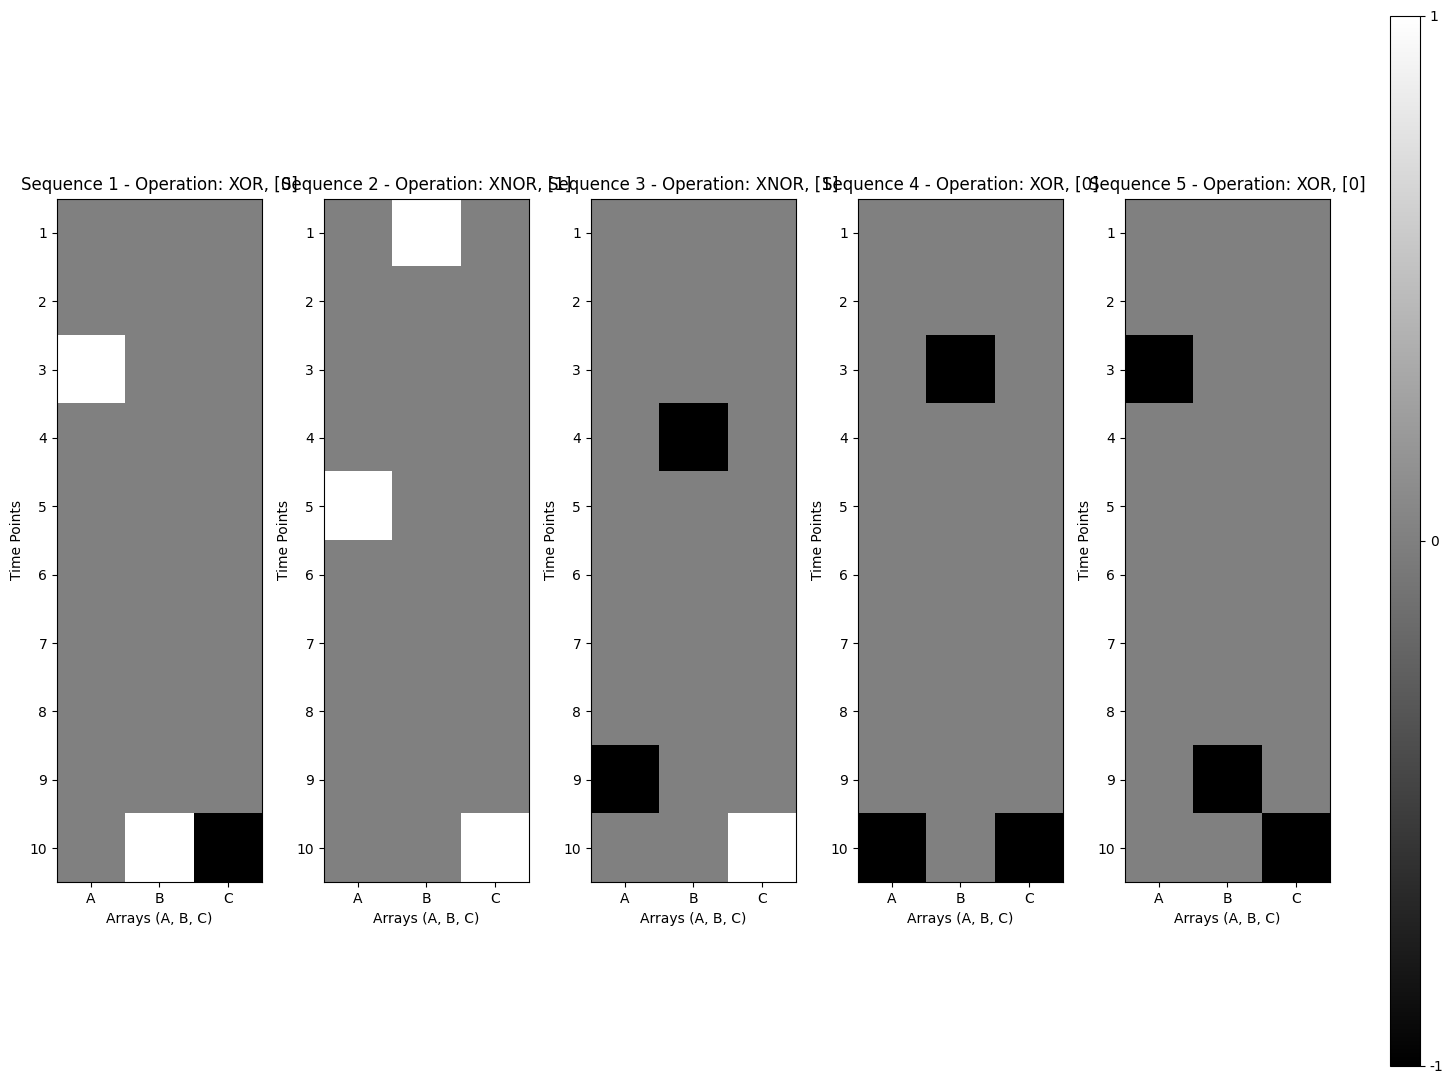

In [15]:
def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax

        operation_title = "XOR" if label == 0 else "XNOR"
        ax.set_title(f"Sequence {i+1} - Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [20]:
parameters_list = []

min_lengths = [3, 10, 10, 20, 20, 40, 40]
max_lengths = [3, 10, 15, 20, 25, 40, 45]
fills = [0, 0.5]
value_pairs = [(-1, 1), (0, 1)]

for min_len, max_len in zip(min_lengths, max_lengths):
    for fill in fills:
        for value_1, value_2 in value_pairs:
            parameters_list.append(
                {
                    "min_length": min_len,
                    "max_length": max_len,
                    "fill": fill,
                    "value_1": value_1,
                    "value_2": value_2,
                }
            )

In [26]:
collectorA = dict()
num_samples = 100
for rep in range(1):
    for params in parameters_list:
        for kind in ["NetRNNWithAttention", "RNN"]:
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            if kind == "NetRNNWithAttention":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            optimizer = optim.Adam(model.parameters())
            error = nn.MSELoss()
            acc = 0.0
            W = []
            A = []
            start_time = time.time()  # Start time of the epoch
            while acc < 0.97:
                model.resetHidden()
                sequences, targets = generateTrainData(num_samples, params)
                # sequences = numpy.array(sequences)  # Convert to numpy array

                divs = []
                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    # Process each sequence individually
                    # seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(
                    #   0
                    # )  # Add batch dimension
                    # target_tensor = torch.tensor(
                    #    target, dtype=torch.float32
                    # )  # Add batch dimension
                    # seq_tensor =torch.Tensor(seq.reshape(1, seq.shape[0], 3))
                    seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(
                        0
                    )  # Add batch dimension
                    target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(
                        0
                    )  # Add batch dimension to target as well
                    output = model(seq_tensor)
                    loss = error(output, target_tensor)
                    loss.backward()
                    optimizer.step()

                    div = output.detach().numpy() - target_tensor.numpy()
                    divs.append(1.0 - abs(div).mean())

                W.append(loss.item())
                acc = mean(divs)
                A.append(acc)
                # print(f"{kind}, rep: {rep}, epoch: {len(A) }, acc: {acc}")

                # Restart training if not converging
                # if acc < 0.97 and len(A) > 2000:
                #     if kind == "RNN":
                #         model = NetRNN(hidden_dim=12, inp=3)
                #     if kind == "NetRNNWithAttention":
                #         model = NetRNNWithAttention(hidden_dim=12, inp=3)
                #     optimizer = optim.Adam(model.parameters())
                #     acc = 0.0
                #     W = []
                #     A = []
                #     print("repeat")
            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA["{0} {1}".format(kind, rep)] = A
            torch.save(model, "models/model_{0}_{1}.model".format(kind, rep))
            print(
                f"{kind}, rep: {rep}, epoch: {len(A)}, acc: {acc:.4f}, params: {params}, time: {epoch_duration:.2f} sec"
            )

NetRNNWithAttention, rep: 0, epoch: 251, acc: 0.9708, params: {'min_length': 15, 'max_length': 20, 'fill': 0, 'value_1': -1, 'value_2': 1}, time: 28.84 sec


KeyboardInterrupt: 

In [ ]:
array_min_length = 5
array_max_length = 10
analysis_interval = 500  # Interval for performing analysis

# Training Loop
for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []  # To store loss values
    A = []  # To store accuracy values

    iteration = 0
    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.float32)

            output = model(seq_tensor)
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)
        # print(f"acc: {acc}")

        # Analysis Part
        if iteration % analysis_interval == 0:
            analysis_sequences, _ = generateTrainData(
                1, array_min_length, array_max_length
            )
            analysis_seq_tensor = torch.tensor(
                analysis_sequences[0], dtype=torch.float32
            ).unsqueeze(0)
            analysis_outputs, analysis_hidden_states = model.step(analysis_seq_tensor)

            # Logging
            # mean_outputs = analysis_outputs.mean(axis=0)
            # std_outputs = analysis_outputs.std(axis=0)
            # print(f"Analysis - Step Function Outputs: Mean = {mean_outputs}, Std Dev = {std_outputs}")

            # mean_hidden_states = analysis_hidden_states.mean(axis=0)
            # std_hidden_states = analysis_hidden_states.std(axis=0)
            # print(f"Analysis - Step Function Hidden States: Mean = {mean_hidden_states}, Std Dev = {std_hidden_states}")

            # Visualization
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 2, 1)
            # plt.plot(analysis_outputs)
            # plt.title("Step Function Outputs Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Output")

            # plt.subplot(1, 2, 2)
            # plt.plot(analysis_hidden_states)
            # plt.title("Hidden States Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Hidden State Value")

            # plt.tight_layout()
            # plt.show()

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")

        iteration += 1

    print(f"RNN {rep}", len(A))

In [199]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_0.model")
model.eval()  # Set the model to evaluation mode


def calculate_accuracy(predictions, targets):
    # Ensure predictions and targets are the same shape
    predictions = predictions.view(-1)
    targets = targets.view(-1)

    # Round predictions to the nearest integer (0 or 1)
    predictions = predictions.round()

    # Calculate the number of correct predictions
    correct = (predictions == targets).float()

    # Calculate accuracy
    acc = correct.sum() / correct.numel()  # Use numel() instead of len()
    return acc.item()


# Generate test data
sequences, targets = generateTrainData(
    100, array_min_length, array_max_length
)  # You can use a different function for test data

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32).squeeze()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        output = model(seq_tensor.unsqueeze(0))  # Add batch dimension
        acc = calculate_accuracy(output, target_tensor)
        total_acc += acc

    # Calculate average accuracy
    avg_acc = total_acc / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")

Average Test Accuracy: 52.00%
